In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import random

In [6]:
words = open('names.txt', 'r').read().splitlines()

In [7]:
# helper functions
chrs = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chrs)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [147]:
N = torch.zeros((27,27), dtype=torch.int32)

In [148]:
for w in words :
    ch = '.' + w + '.'
    for w1,w2 in zip(ch, ch[1:]) :
        ix1 = stoi[w1]
        ix2 = stoi[w2]
        N[ix1, ix2] += 1

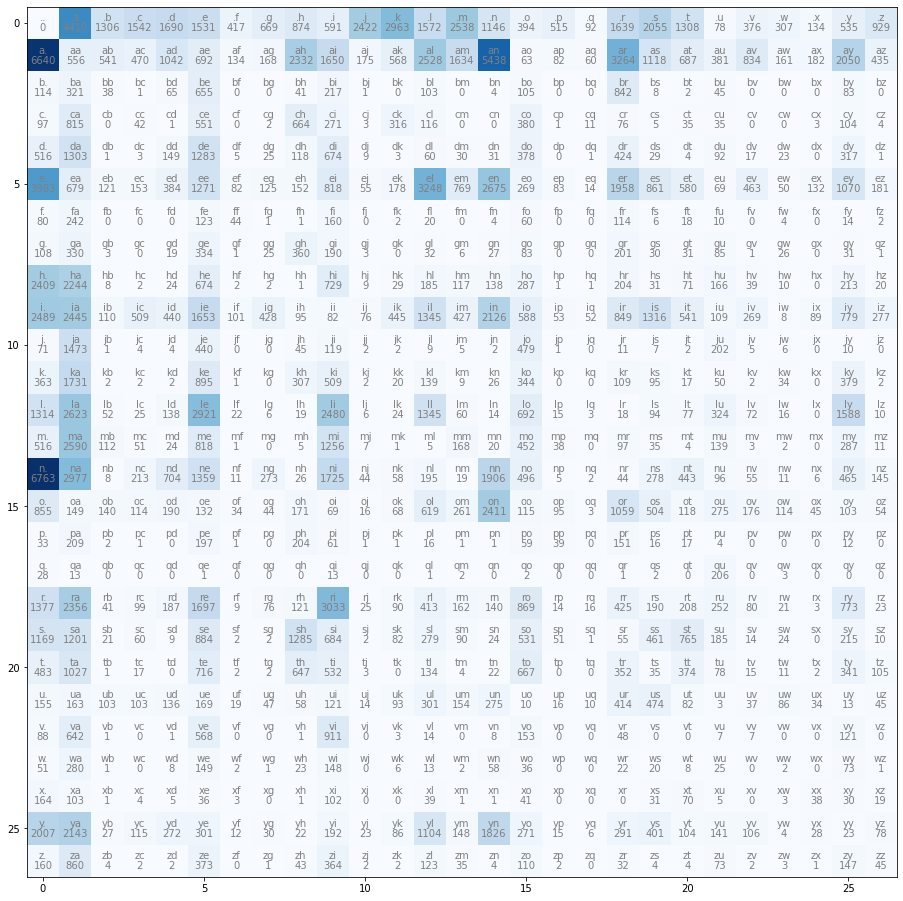

In [10]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27) :
    for j in range(27) :
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', c='grey')
        plt.text(j, i, N[i,j].item(), ha='center', va='top', c='grey')

In [97]:
# making the probability matrix
P = (N+1).float() # smoothing so that no combination has zero probability
P = P / P.sum(axis=1, keepdims=True) # see broadcasting semantics

# the smoothing prevents infinite nll on specific inputs
# this is equivalent to addition of regularisation in neural network jargon
# this is required to obtain robustness during inference (no infinite losses)

In [98]:
# making a bigram name generator
for i in range(10) :
    ix = 0
    while True :
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True).item()
        if ix==0 : break
        print(itos[ix], end='')
    print()

blahenasetsenahatonah
ror
dimbdainosi
s
kin
sa
blakoreeyal
alaladary
ttho
dayusade


In [14]:
# getting the result using a gradient-based optimisation approach
# we set up a single-layer NN, having 27 inputs (one-hot encoded gram) and 27 neurons, which
# are then passed through a softmax
# since this is a classification problem, we use nll as out loss function (not the complete entropy)
# the optimal loss should match the nlll that we get using the previous approach

In [99]:
# getting the optimal loss value
optimal_nll = 0
n = 0
for w in words :
    ch = '.' + w + '.'
    for w1, w2 in zip(ch, ch[1:]) :
        ix1 = stoi[w1]
        ix2 = stoi[w2]
        prob = P[ix1, ix2]
        optimal_nll -= prob.log()
        n += 1
optimal_nll /= n
optimal_nll

tensor(2.4544)

In [100]:
xs = []
ys = []
for w in words :
    ch = '.' + w + '.'
    for w1, w2 in zip(ch, ch[1:]) :
        ix1 = stoi[w1]
        ix2 = stoi[w2]
        xs.append(ix1)
        ys.append(ix2)
# getting the entire corpus of input data
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [101]:
# weights
w = torch.randn((27,27), requires_grad=True)

In [102]:
losslog = []
for _ in range(100) : # 3 100 epochs
    # fwd pass
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ w
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(len(ys)), ys].log().mean() # nll
    
    losslog.append(loss)
    
    # backward pass
    w.grad = None
    loss.backward()
    w.data -= 50*w.grad


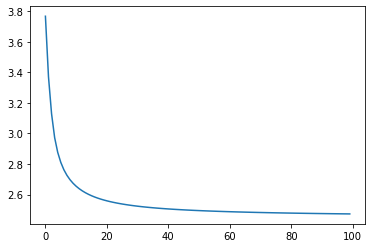

In [103]:
plt.plot([x.item() for x in losslog])

In [104]:
final_loss = losslog[-1]
final_loss


tensor(2.4728, grad_fn=<NegBackward>)

In [115]:
# sampling from the neural network
for i in range(5) :
    ix = 0
    while True :
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ w
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)
        ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
        if ix==0 : break
        print(itos[ix], end='')
    print()

drsa
k
bsasosoh
ah
fier


In [116]:
# trying a trigram model
# First by counting, then by the neural network approach

In [156]:
# helper functions
chrs = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chrs)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [167]:
# to get probability of beginning letter
beg = torch.zeros(27)
for w in words :
    char = w[0]
    ix = stoi[char]
    beg[ix] += 1
beg /= beg.sum()
beg

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [227]:
N = torch.zeros((27, 27, 27), dtype=torch.int32)
for w in words :
    ch = '.' + w + '.'
    for w1,w2,w3 in zip(ch, ch[1:], ch[2:]) :
        ix1 = stoi[w1]
        ix2 = stoi[w2]
        ix3 = stoi[w3]
        N[ix1, ix2, ix3] += 1

In [240]:
P = (N+1).float()
P /= P.sum(2, keepdims=True)

P1 = N.float()
P1 /= P1.sum(2, keepdims=True)
P1 = P1.nan_to_num(nan=0)

In [177]:
# Names starting in s
for _ in range(5) :
    ix1 = 0
    ix2 = torch.multinomial(beg, num_samples=1, replacement=True).item()
    print(itos[ix2], end='')
    while True :
        probs = P[ix1,ix2]
#         print(probs)
        # probs = torch.ones(27)/27
        ix3 = torch.multinomial(probs, num_samples=1, replacement=True).item()
        if ix3==0 : break
        print(itos[ix3], end='')
        ix1, ix2 = ix2, ix3
    print()

ne
hakariaspriel
kate
mykymakyle
se


In [244]:
# getting the optimal loss value
optimal_nll = 0
n = 0
for w in words :
    ch = '.' + w + '.'
    for w1, w2, w3 in zip(ch, ch[1:], ch[2:]) :
        ix1 = stoi[w1]
        ix2 = stoi[w2]
        ix3 = stoi[w3]
        prob = P1[ix1, ix2, ix3]
        optimal_nll -= prob.log()
        n += 1
optimal_nll /= n
optimal_nll

tensor(2.0620)

In [178]:
# now training a neural network for the same task
# input will be sum of one_hot encodings of two letters
# one layer containing 27 neurons, followed by softmax
# loss : nll

In [248]:
xs = []
ys = []
for w in words :
    ch = '.' + w + '.'
    for w1, w2, w3 in zip(ch, ch[1:], ch[2:]) :
        ix1 = stoi[w1]
        ix2 = stoi[w2]
        ix3 = stoi[w3]
        xs.append([ix1, ix2])
        ys.append(ix3)
# getting the entire corpus of input data
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [249]:
w = torch.randn((27,27), requires_grad=True)
losslog = []

In [257]:
# losslog = []
for _ in range(100) : # 100 epochs
    # fwd pass
    xenc1 = F.one_hot(xs[:,0]).float()
    xenc2 = F.one_hot(xs[:,1]).float()
    xenc = xenc1 + xenc2
    logits = xenc @ w
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(len(ys)), ys].log().mean() # nll
    
    losslog.append(loss)
    
    # backward pass
    w.grad = None
    loss.backward()
    w.data -= 10*w.grad
losslog[-1]

tensor(2.4096, grad_fn=<NegBackward>)

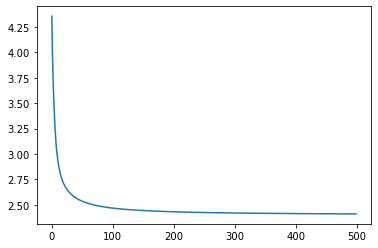

In [258]:
plt.plot([x.item() for x in losslog])

In [259]:
# sampling from the neural network
for i in range(10) :
    ix1 = 0
    ix2 = torch.multinomial(beg, num_samples=1, replacement=True).item()
    print(itos[ix2], end='')
    while True :
        xenc1 = F.one_hot(torch.tensor([ix1]), num_classes=27).float()
        xenc2 = F.one_hot(torch.tensor([ix2]), num_classes=27).float()
        xenc = xenc1 + xenc2
        logits = xenc @ w
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)
        ix3 = torch.multinomial(probs, num_samples=1, replacement=True).item()
        if ix3==0 : break
        print(itos[ix3], end='')
        ix1, ix2 = ix2, ix3
    print()

mashealny
akmeyn
lihi
cual
naelan
rae
dmey
kezyen
tpie
avnei


In [271]:
# A different method
# concatenating the inputs into one 27*2=54 length vector
# double the number of parameters, but higher representational power of the NN
w = torch.randn((54,27), requires_grad=True)
losslog = []

In [281]:

for _ in range(200) : # 100 epochs
    # fwd pass
    xenc1 = F.one_hot(xs[:,0]).float()
    xenc2 = F.one_hot(xs[:,1]).float()
    xenc = torch.cat([xenc1, xenc2], dim=1)
    logits = xenc @ w
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(len(ys)), ys].log().mean() # nll
    
    losslog.append(loss)
    
    # backward pass
    w.grad = None
    loss.backward()
    w.data -= 50*w.grad
losslog[-1]

tensor(2.2386, grad_fn=<NegBackward>)

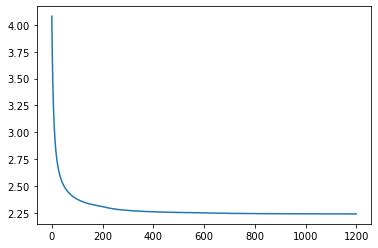

In [283]:
plt.plot([x.item() for x in losslog])

In [286]:
# sampling from the neural network
for i in range(10) :
    ix1 = 0
    ix2 = torch.multinomial(beg, num_samples=1, replacement=True).item()
    print(itos[ix2], end='')
    while True :
        xenc1 = F.one_hot(torch.tensor([ix1]), num_classes=27).float()
        xenc2 = F.one_hot(torch.tensor([ix2]), num_classes=27).float()
        xenc = torch.cat([xenc1, xenc2], dim=1)
        logits = xenc @ w
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)
        ix3 = torch.multinomial(probs, num_samples=1, replacement=True).item()
        if ix3==0 : break
        print(itos[ix3], end='')
        ix1, ix2 = ix2, ix3
    print()

ymar
ni
soubrestoni
briol
ahadommaimass
jey
cce
kel
for
re
